# select significant electrodes for listen task

In [12]:
import numpy as np
from scipy import stats
import os
import scipy.io as scio
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

bands_list = ['theta', 'alpha', 'beta1', 'beta2', 'low gamma', 'high gamma']
freq_list=[400]
HS_list=[68, 69, 75, 79, 82, 83, 84, 85, 86]

In [3]:
def load_band_data(data_path, HS, band):
    keys = ['功课 listen', '力果 listen', '作业 listen', '树叶 listen', '对十 listen', '绿草 listen']
    file_path = os.path.join(data_path, f"HS{HS}block_{band}.npy")
    block_data = np.load(file_path, allow_pickle=True).item()
    # print(block_data.keys())
    block_data_all = []
    for word in keys:
        block_data_all.append(block_data[word].transpose(2, 0, 1))
        # print(block_data[word].shape) #(256, 800, 36) (n_electrode, n_time, n_trails)
    block_data_all = np.vstack(block_data_all)
    
    return block_data_all
                
import numpy as np
from scipy import stats

def calculate_p_values(ecogReading_task):
    """
    计算每个电极在每个时间点的 p 值。
    参数:
    - ecogReading_task: numpy.ndarray, 
    shape (n_trials, n_electrodes, n_times)
    返回:
    - p_values: numpy.ndarray, shape (n_electrodes, n_times)
    """
    # 获取形状信息
    n_trials, n_electrodes, n_times = ecogReading_task.shape

    # 定义基线时间窗（取最后0.2s对应的时间点范围）
    start = n_times - 80
    end = n_times

    p_values = np.zeros((n_electrodes, n_times))

    for electrode_idx in range(n_electrodes):
        electrode_data = ecogReading_task[:, electrode_idx, :]
        baseline = electrode_data[:, start:end].reshape(-1)
        for time_idx in range(0, n_times-80):
            current_data = electrode_data[:, time_idx]
            baseline_valid = baseline[~np.isnan(baseline)]
            current_data_valid = current_data[~np.isnan(current_data)]
            if len(current_data_valid) > 0 and len(baseline_valid) > 0:
                p_values[electrode_idx, time_idx] = stats.ttest_ind(
                    baseline_valid, current_data_valid, alternative='less'
                ).pvalue
            else:
                p_values[electrode_idx, time_idx] = np.nan

    return p_values


In [3]:
base_path = '/public/DATA/overt_reading/Blocked_data/'  # 数据基础路径
save_base_path = '/public/DATA/overt_reading/t-test_results/'
for HS in HS_list:
    os.makedirs(os.path.join(save_base_path, f'HS{HS}'), exist_ok=True)
    band_p_values = {}
    for band in bands_list:
        band_ecog_data = load_band_data(base_path, HS, band)
        p_value = calculate_p_values(band_ecog_data)
        band_p_values[band] = p_value
    np.save(os.path.join(save_base_path, f'HS{HS}/listen_allband_p_values.npy'), band_p_values)

# plot erps and mark significant electrodes for subjects

In [9]:
from statsmodels.stats.multitest import multipletests

def adjust_p_values(p_values, method='fdr_bh'):
    """
    对 p 值进行多重检验矫正。
    参数:
    - p_values: numpy.ndarray, 原始 p 值数组，形状为 (n_electrodes, n_times)。
    - method: str, 多重检验方法，默认为 'fdr_bh'。
    返回:
    - adjusted_p_values: numpy.ndarray, 矫正后的 p 值，形状与输入相同。
    """
    n_electrodes, n_times = p_values.shape
    adjusted_p_values = np.full_like(p_values, np.nan)  # 初始化矫正后的 p 值数组

    for time_idx in range(n_times):
        time_p_values = p_values[:, time_idx]
        valid_mask = ~np.isnan(time_p_values)  # 筛选有效 p 值
        if np.any(valid_mask):
            # 对当前时间点的 p 值进行多重检验矫正
            _, adj_pvals, _, _ = multipletests(time_p_values[valid_mask], method=method)
            adjusted_p_values[valid_mask, time_idx] = adj_pvals

    return adjusted_p_values

def get_significant_electrodes_with_continuity_and_points(
    p_values_dict, start_time, end_time, threshold=0.01, min_continuous_points=20
):
    """
    获取显著电极的索引及显著时间点。
    Args:
        p_values_dict (dict): 每个频段的 p 值数据，形如 {band: p_values_array}。
        start_time (int): 分析起始时间点的索引。
        end_time (int): 分析结束时间点的索引。
        threshold (float): 显著性阈值。
        min_continuous_points (int): 连续显著时间点的最小数量。
    Returns:
        dict: 每个频段显著电极及显著时间点 {band: {electrode_idx: list_of_time_indices}}。
    """
    significant_electrodes = {}
    for band, p_values in p_values_dict.items():
        band_significant = {}
        for electrode_idx in range(p_values.shape[0]):
            # 找出该电极的显著时间点
            significant_mask = p_values[electrode_idx, start_time:end_time] < (
                threshold / 256 / (end_time - start_time)
            )
            significant_blocks = np.diff(np.where(np.concatenate(([0], significant_mask, [0])))[0]) - 1
            significant_points = []

            # 如果有连续显著时间点，记录时间索引
            if np.any(significant_blocks >= min_continuous_points):
                continuous_start_idx = np.where(significant_mask)[0]
                for idx, count in enumerate(significant_blocks):
                    if count >= min_continuous_points:
                        start = continuous_start_idx[idx]
                        end = start + count
                        # 显著点索引需要加上 start_time 的偏移量
                        significant_points.extend(range(start, end))
                band_significant[electrode_idx] = significant_points
        significant_electrodes[band] = band_significant
    return significant_electrodes

def nansem(a, axis=0):
    return np.nanstd(a, axis=axis) / np.sqrt(a.shape[axis])

def plot_filled_sem(a, xvals, ax=None, color=None, ylim=None, alpha=0.6, label=None):
    if ax is None:
        fig, ax = plt.subplots()
    # print(a.shape)
    # print(xvals.shape)
    mean = np.nanmean(a, axis=0)
    # print(mean.shape)
    
    sem = nansem(a, axis=0)
    # print(sem.shape)
    # print(mean.shape, sem.shape)
    ax.axvline(0, color='gray', linewidth=0.5)
    #ax.axhline(0, color='gray', linewidth=0.5)

    if color is not None:
        h = ax.fill_between(xvals, mean - sem, mean + sem, alpha=alpha, color=color, label=label)
    else:
        h = ax.fill_between(xvals, mean - sem, mean + sem, alpha=alpha, label=label)

    if ylim is not None:
        ax.set(ylim=ylim)
    ax.set(xlim=(xvals[0], xvals[-1]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return h

import numpy as np
import matplotlib.pyplot as plt

def plt_erps_significant_electrodes(ecog_data, significant_electrodes, start_time, end_time, title="ERP with Significant Points"):
    n_electrodes = ecog_data.shape[1]  # 获取电极数量
    electrode_list = [i for i in range(n_electrodes)]

    n_elec = len(electrode_list)

    fig, axs = plt.subplots(int(n_elec/8), 8, figsize=(25, int(n_elec*25/128)))
    axs = axs.flatten()  # 将 axs 转换为一维数组，方便索引

    for i, electrode_index in enumerate(electrode_list):
        # 提取 ERP 数据
        data_erp = ecog_data[:, electrode_index, int(start_time - 200):int(end_time)]
        
        # 创建时间轴
        xval = np.linspace(-0.2, 0.75, data_erp.shape[2])
        if i in significant_electrodes:
            plot_filled_sem(data_erp, xvals=xval, ax=axs[i], color='red')
        else:
            plot_filled_sem(data_erp, xvals=xval, ax=axs[i], color='blue')
        
        # 设置子图的标题和标签
        axs[i].set_title(f'electrode {electrode_index}', fontsize=8)
        # axs[i].legend()
        axs[i].legend(loc='upper right', fontsize='small', frameon=True)
            
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('Amplitude (a.u.)')


    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(title, fontsize=16, y=1)
    plt.tight_layout()
    plt.show()

def plt_erps_significant_electrodes_with_points(ecog_data, significant_electrodes, start_time, end_time, threshold=0.05, title="ERP with Significant Points"):
    """
    绘制 ERP 并在显著电极曲线上标注连续显著点。
    Args:
        ecog_data (ndarray): ERP 数据，形状为 (n_samples, n_electrodes, n_timesteps)。
        significant_electrodes (dict): 每个电极的显著时间点 {electrode_idx: list_of_time_indices}。
        p_values (ndarray): 每个电极的 p 值数组，形状为 (n_electrodes, n_timesteps)。
        threshold (float): 显著性阈值。
    """
    n_electrodes = ecog_data.shape[1]  # 获取电极数量
    electrode_list = [i for i in range(n_electrodes)]

    n_elec = len(electrode_list)

    fig, axs = plt.subplots(int(n_elec / 8), 8, figsize=(25, int(n_elec * 25 / 128)))
    axs = axs.flatten()  # 将 axs 转换为一维数组，方便索引

    for i, electrode_index in enumerate(electrode_list):
        # 提取 ERP 数据
        data_erp = ecog_data[:, electrode_index, int(start_time):int(end_time)]
        # print(data_erp.shape)
        mean_erp = np.nanmean(data_erp, axis=0)  # 计算均值 ERP
        sem_erp = np.nanstd(data_erp, axis=0) / np.sqrt(data_erp.shape[0])  # 计算标准误差
        xval = np.linspace(0, 0.75, (end_time-start_time))  # 创建时间轴
        
        # 绘制平均 ERP 曲线
        axs[i].plot(xval, mean_erp, color='red' if electrode_index in significant_electrodes else 'blue', label='ERP')
        axs[i].fill_between(xval, mean_erp - sem_erp, mean_erp + sem_erp, alpha=0.2, color='red' if electrode_index in significant_electrodes else 'blue')

        # 标注显著时间点
        if electrode_index in significant_electrodes:
            significant_points = significant_electrodes[electrode_index]
            adjusted_significant_points = [point - int(start_time) for point in significant_points]
            # print(significant_points)
            # print(adjusted_significant_points)
            axs[i].scatter(xval[adjusted_significant_points], mean_erp[adjusted_significant_points] + 0.05, color='black', marker='*', s=10, label='Significant Points')
        
        axs[i].axvline(0, color='gray', linewidth=0.5)
        
        # 设置子图的标题和标签
        axs[i].set_title(f'Electrode {electrode_index}', fontsize=8)
        axs[i].legend(loc='upper right', fontsize='small', frameon=True)
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('Amplitude (a.u.)')

    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(title, fontsize=16, y=1)
    plt.tight_layout()
    plt.show()



In [10]:
base_path = '/public/DATA/overt_reading/Blocked_data/'  # 数据基础路径
save_base_path = '/public/DATA/overt_reading/t-test_results/'

listen_time = [0, int(0.75*400)]
task_time = {'listen': listen_time}

for HS in HS_list:  
    save_path_sigelecs = os.path.join(save_base_path, f'HS{HS}')
    print(f'======================HS{HS}===========================') 
    p_values = np.load(os.path.join(save_base_path, f'HS{HS}/listen_allband_p_values.npy'), allow_pickle=True).item()
    for task, times in task_time.items():
        print(f'======================{task}===========================')
        significant_electrodes = get_significant_electrodes_with_continuity_and_points(p_values, times[0], times[1], threshold=0.01, min_continuous_points=10)
        np.save(os.path.join(save_path_sigelecs, f'{task}_allbands_sigelecs.npy'), significant_electrodes)
        for band in bands_list:
            print(f'Number of significant electrodes for {band} band: {len(significant_electrodes[band])}')
    

======================HS68===========================
======================listen===========================
Number of significant electrodes for theta band: 0
Number of significant electrodes for alpha band: 0
Number of significant electrodes for beta1 band: 1
Number of significant electrodes for beta2 band: 0
Number of significant electrodes for low gamma band: 0
Number of significant electrodes for high gamma band: 0
======================HS69===========================
======================listen===========================
Number of significant electrodes for theta band: 0
Number of significant electrodes for alpha band: 0
Number of significant electrodes for beta1 band: 0
Number of significant electrodes for beta2 band: 1
Number of significant electrodes for low gamma band: 0
Number of significant electrodes for high gamma band: 2
======================HS75===========================
======================listen===========================
Number of significant electrodes for the

In [ ]:
base_path = '/public/DATA/overt_reading/Blocked_data/'  # 数据基础路径
save_base_path = '/public/DATA/overt_reading/t-test_results/'

listen_time = [0, int(0.75*400)]

task_time = {'listen': listen_time}

for HS in HS_list:
    for task, times in task_time.items():
        significant_electrodes = np.load(os.path.join(save_base_path, f'HS{HS}/{task}_allbands_sigelecs.npy'), allow_pickle=True).item()
        for band in bands_list:
            if len(significant_electrodes[band]) == 0:
                continue
            band_ecog_data = load_band_data(base_path, HS, band)
            band_p_values = p_values[band]
            # 绘制显著电极的 ERP以及标注显著点
            plt_erps_significant_electrodes_with_points(band_ecog_data, significant_electrodes[band], times[0], times[1], title=f"{task} Erps {band} - {HS}")
            break

# plot all significant electrodes on brain

In [15]:
# 统计所有被试在每个band的显著电极
for task in task_time.keys():
    task_band_sig_elec = {}
    if task not in task_band_sig_elec:
        task_band_sig_elec[task] = {}
    HS_band_sig_elec = {}
    for HS in HS_list:
        save_path_sigelecs = f'/public/DATA/overt_reading/t-test_results/HS{HS}'
        allbands_sigelecs = np.load(os.path.join(save_path_sigelecs, f'{task}_allbands_sigelecs.npy'), allow_pickle=True).item()
        band_elecs = {}
        for band in bands_list:
            # print(allbands_sigelecs[band].keys())
            band_elecs[band] = list(allbands_sigelecs[band].keys())

        if HS not in HS_band_sig_elec:
            HS_band_sig_elec[f'HS{HS}'] = {}
        HS_band_sig_elec[f'HS{HS}'] = band_elecs
    task_band_sig_elec[f'{task}'] = HS_band_sig_elec
    # print(task_band_sig_elec)
    np.save(os.path.join(f'/public/DATA/overt_reading/t-test_results', f'{task}_all_sigelecs.npy'), task_band_sig_elec)

for task in task_time.keys():
    # print(task)
    task_all_sigelecs = np.load(os.path.join(f'/public/DATA/overt_reading/t-test_results', f'{task}_all_sigelecs.npy'), allow_pickle=True).item()
    print(task_all_sigelecs)

{'listen': {'HS68': {'theta': [], 'alpha': [], 'beta1': [173], 'beta2': [], 'low gamma': [], 'high gamma': []}, 'HS69': {'theta': [], 'alpha': [], 'beta1': [], 'beta2': [178], 'low gamma': [], 'high gamma': [152, 165]}, 'HS75': {'theta': [], 'alpha': [], 'beta1': [], 'beta2': [], 'low gamma': [139, 156, 221], 'high gamma': [72, 100, 117, 138, 141, 142, 153, 154, 191]}, 'HS79': {'theta': [], 'alpha': [], 'beta1': [], 'beta2': [], 'low gamma': [169, 228], 'high gamma': [82, 153, 157, 168, 169, 189]}, 'HS82': {'theta': [], 'alpha': [], 'beta1': [], 'beta2': [], 'low gamma': [5, 22, 38, 45, 54, 63, 71, 77, 92], 'high gamma': [5, 6, 8, 10, 22, 23, 38, 43, 54, 69, 72]}, 'HS83': {'theta': [], 'alpha': [], 'beta1': [253], 'beta2': [55], 'low gamma': [57, 70, 71, 72, 204], 'high gamma': [12, 57, 205, 223]}, 'HS84': {'theta': [], 'alpha': [], 'beta1': [], 'beta2': [], 'low gamma': [], 'high gamma': [34, 49, 50, 157]}, 'HS85': {'theta': [], 'alpha': [164], 'beta1': [], 'beta2': [74, 75], 'low gam

In [ ]:
def load_all_subjects_sigelecs(HS_list, band, task_all_sigelecs):
    all_coords, all_HS, all_anatomy, all_elecs = [], [], [], []
    path = '/public/DATA/overt_reading/'
    for HS in HS_list:
        subject_str = f"HS{HS}"
        anatomy = scio.loadmat(path+f"/elecs/All_elecs/HS{HS}_elecs_all_warped.mat")['anatomy']
        band_sigelecs = task_all_sigelecs[f"HS{HS}"][band]
        # Load 3D electrode coordinates in MNI space
        path = '/public/DATA/overt_reading/'

        coords = scio.loadmat(path + f"/elecs/All_elecs/{subject_str}_warped_elec_pos2D.mat")['elecmatrix']
        if len(band_sigelecs) == 0 :
            continue
        for i, sigelecs in enumerate(band_sigelecs):
            all_coords.append(coords[sigelecs])  # Append each electrode's coordinates
            all_HS.append(HS)        # Append each electrode's HS
            all_anatomy.append(anatomy[sigelecs][3][0])
            all_elecs.append(sigelecs)
            
    return np.array(all_coords), np.array(all_HS), np.array(all_anatomy), np.array(all_elecs)

def plot_brain_surface_with_sigelecs(all_coords, all_HS, all_anatomy, all_elecs, band, task):
    # Load 2D brain image
    path = '/public/DATA/overt_reading/'
    img = mpimg.imread(path +"/elecs/Brain2D/MNI152_brain2D.png")
    marker_type = {}
    marker_type["68"] = "D"
    marker_type["69"] = "*"
    marker_type["75"] = "s"
    marker_type["79"] = "P"
    marker_type["82"] = "o"
    marker_type["83"] = "v"
    marker_type["84"] = "^"
    marker_type["85"] = "X"
    marker_type["86"] = "p"

    color_set_region = {'superiorfrontal': 'grey',
             'superiortemporal': 'purple',
             'inferiorparietal': 'skyblue',
             'rostralmiddlefrontal': 'black',
             'parstriangularis': 'darkgreen',
             'superiorparietal': 'orange',
             'postcentral': 'red',
             'parsopercularis': 'gold',
             'middletemporal': 'greenyellow',
             'inferiortemporal': 'pink',
             'parsorbitalis': 'olive',
             'supramarginal': 'green',
             'lateraloccipital': 'navy',
             'bankssts': 'rosybrown',
             'precentral': 'blue',
             'caudalmiddlefrontal': 'slategrey'}
   
    plt.subplots(figsize=(15,15))

    plt.imshow(img)
    for i, elec in enumerate(all_elecs):
        plt.scatter(all_coords[i, 0], all_coords[i, 1], c=color_set_region[all_anatomy[i]], marker=marker_type[str(all_HS[i])], alpha=0.7)
    # plt.scatter(all_coords[:, 0], all_coords[:, 1], alpha=0.7, )
    # 创建虚拟点用于图例
    legend_handles = []
    for region, color in color_set_region.items():
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=region))
    
    # 添加图例
    plt.legend(handles=legend_handles, title="Brain Regions", loc='upper right', fontsize='small', title_fontsize='medium')

    plt.title(f'{task} Significant Electrodes(p_value<{0.01}) {band} - number {len(all_elecs)}')
    plt.axis('off')
    plt.show()
    

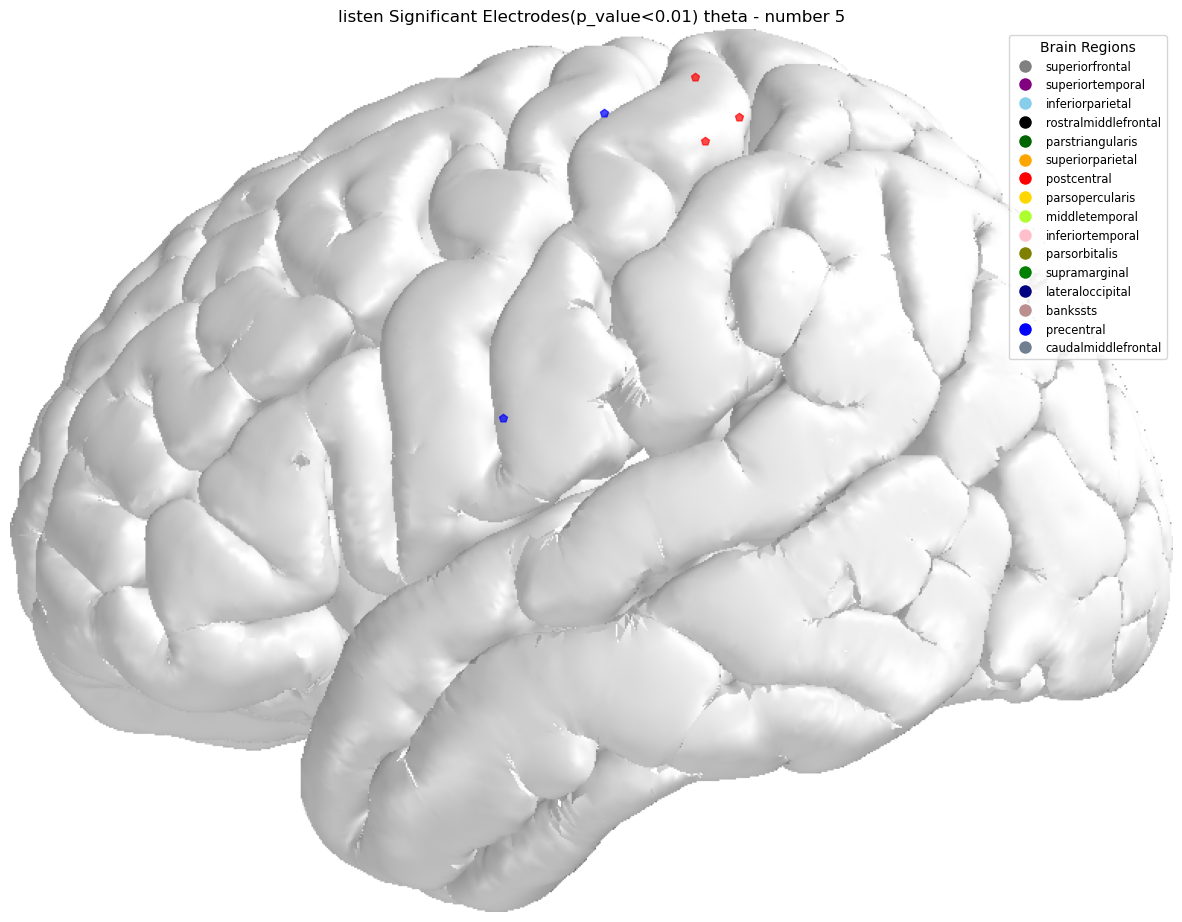

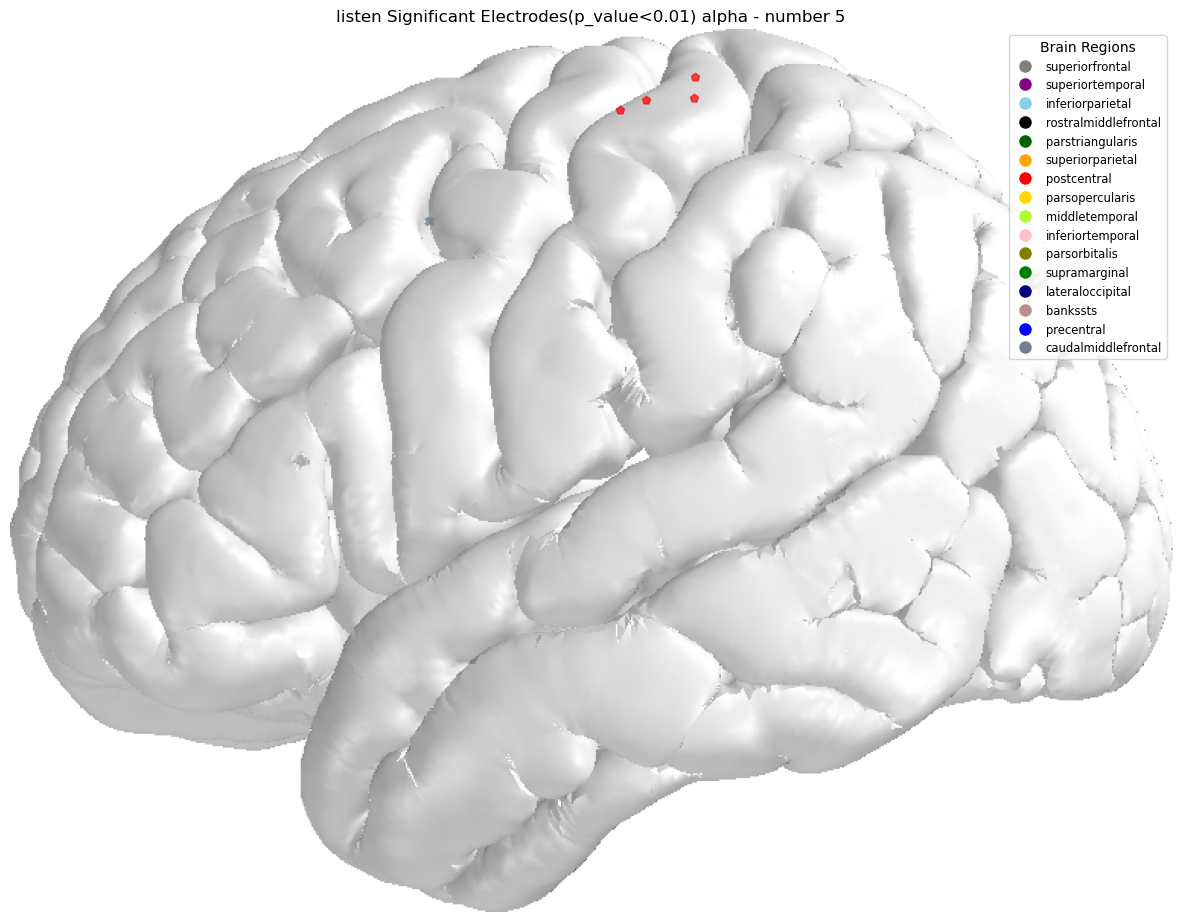

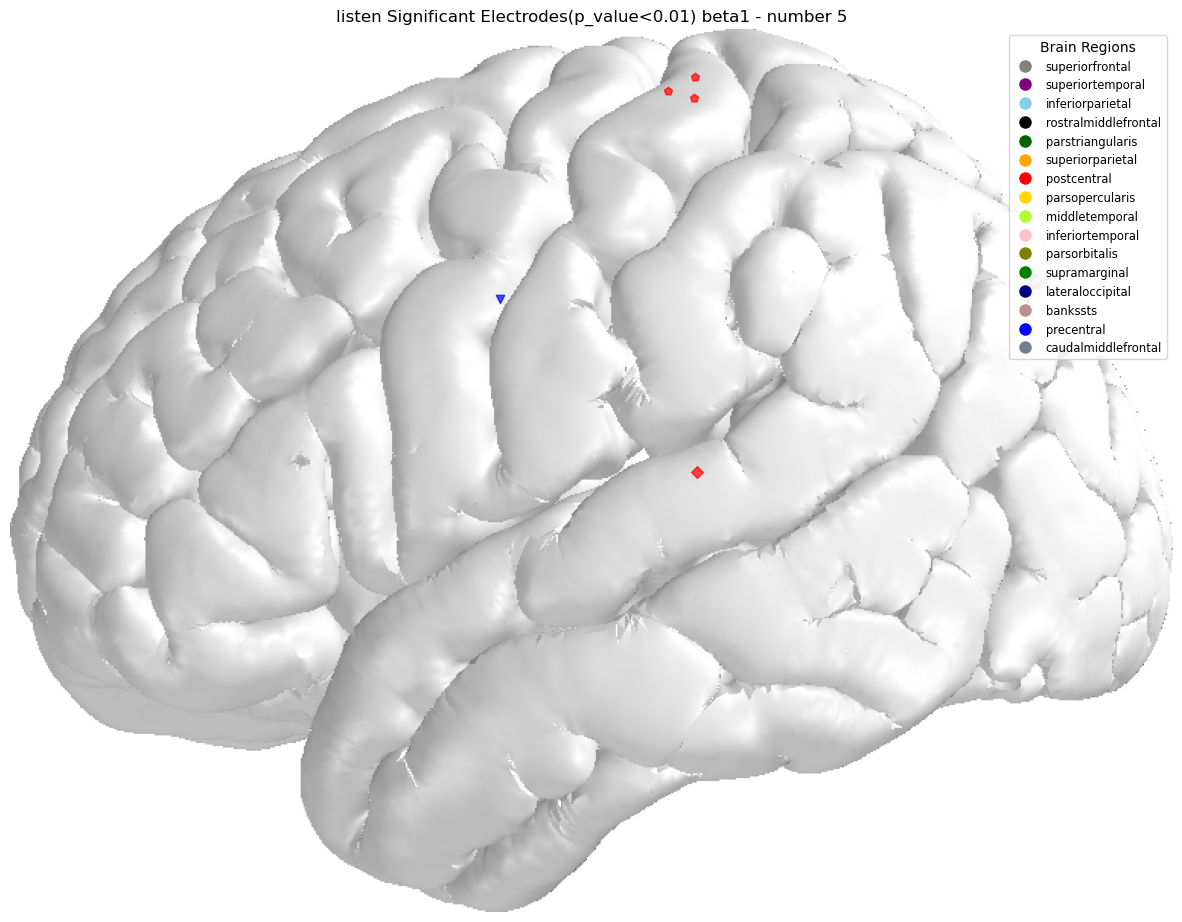

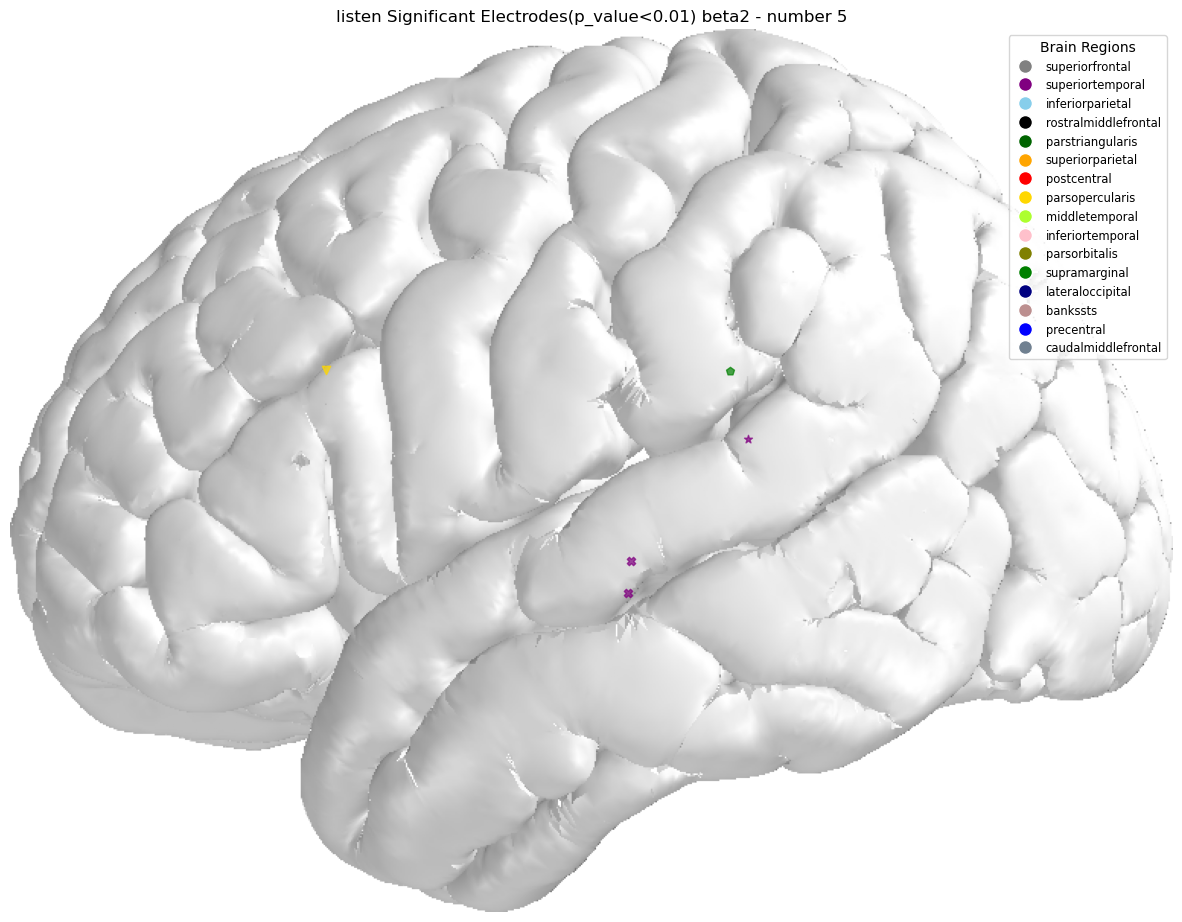

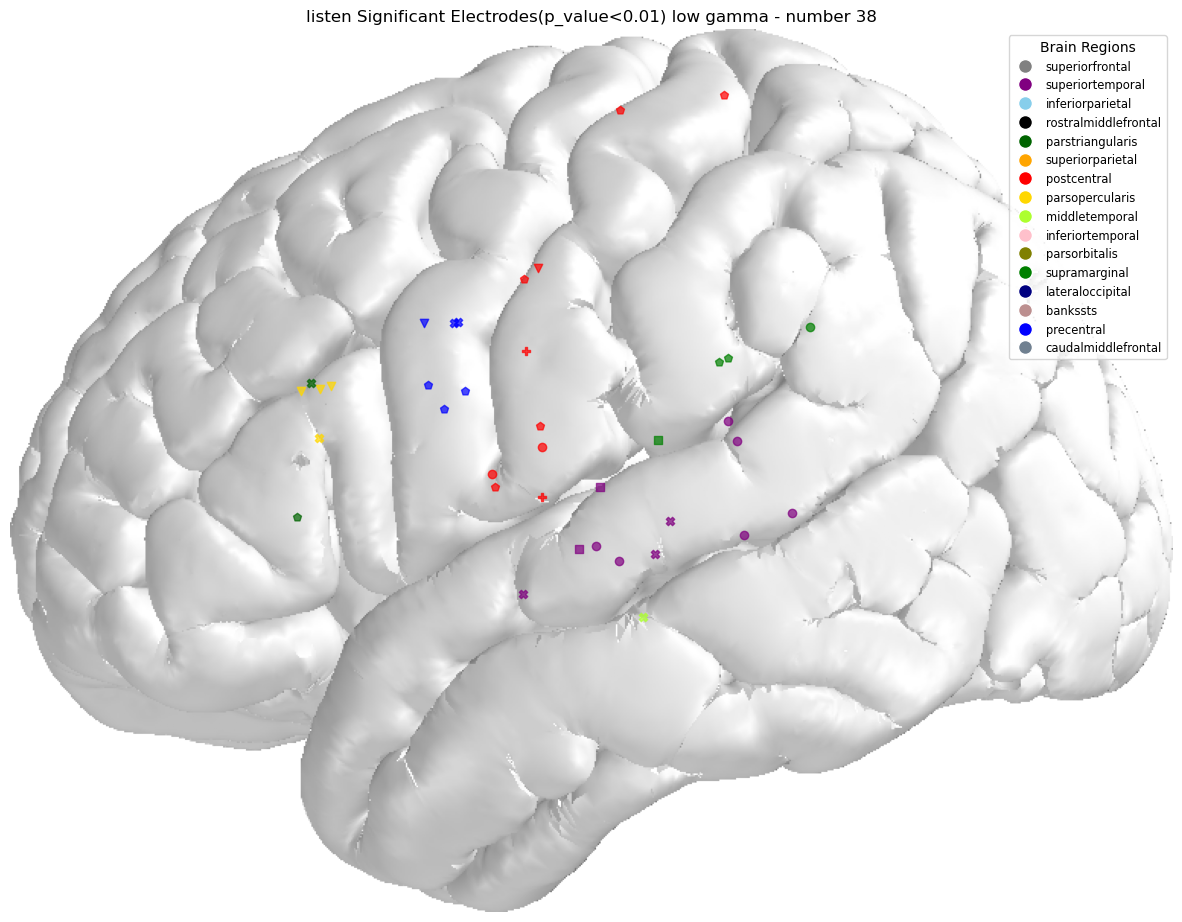

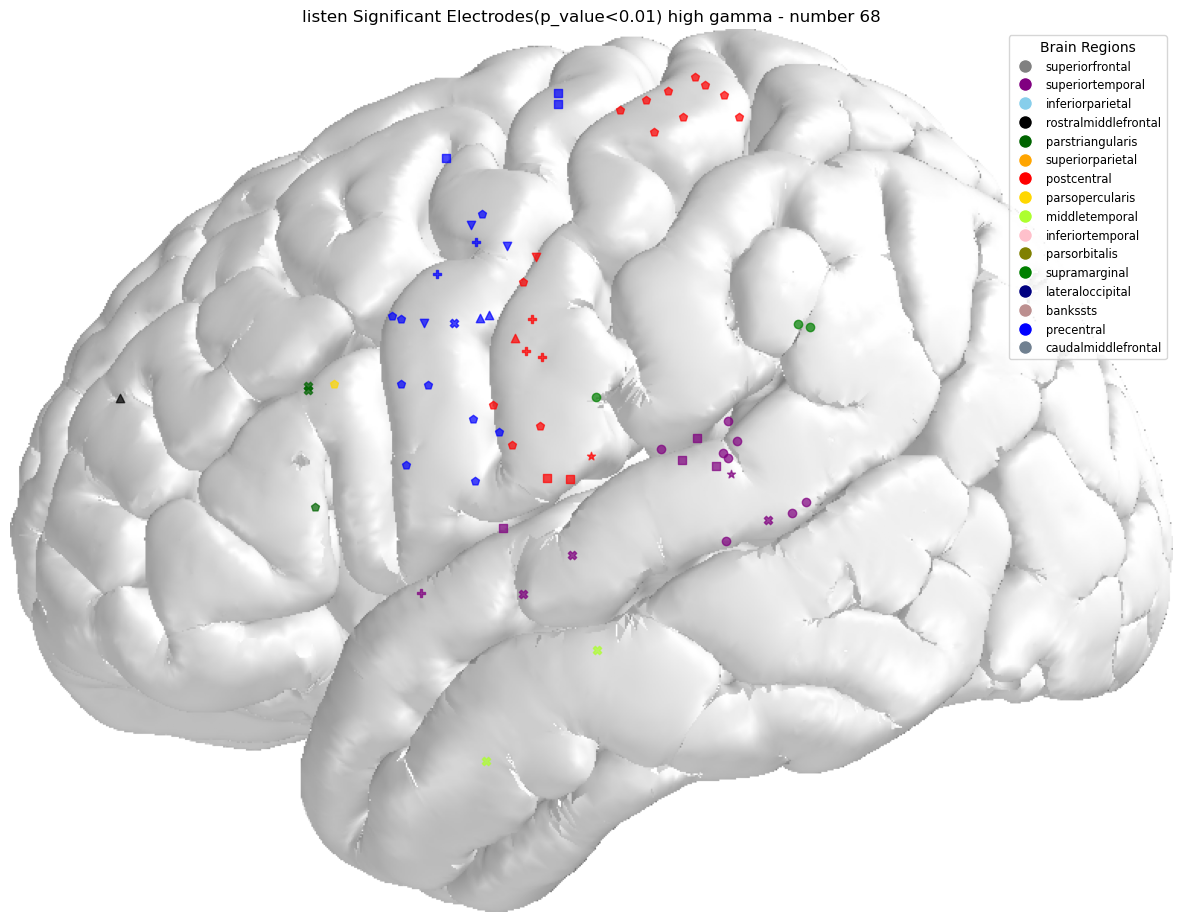

In [17]:
listen_time = [0, int(0.75*400)]
task_time = {'listen': listen_time}
for band in bands_list:
    for task, time in task_time.items():
        task_all_sigelecs = np.load(os.path.join(f'/public/DATA/overt_reading/t-test_results', f'{task}_all_sigelecs.npy'), allow_pickle=True).item()
        # print(task_all_sigelecs[f'{task}'][f'HS68']['theta'])
        all_coords, all_HS, all_anatomy, all_elecs = load_all_subjects_sigelecs(HS_list, band, task_all_sigelecs[f'{task}'])
        plot_brain_surface_with_sigelecs(all_coords, all_HS, all_anatomy, all_elecs, band, task)

# Plot ration of significant electrodes on different brain regions

In [23]:
def Count_electrodes_of_regions(HS_list, freq_list, band, task_all_sigelecs):
    elec_region, sigelec_region = {}, {}
    for HS in HS_list:
        band_sigelec = task_all_sigelecs[f'HS{HS}'][band]
        anatomy = scio.loadmat(f"/public/DATA/overt_reading/elecs/All_elecs/HS{HS}_elecs_all_warped.mat")['anatomy']
        for freq in freq_list:
            for elec in range(256):
                region = anatomy[elec][3][0]
                if region not in elec_region:
                    elec_region[region] = 0
                elec_region[region] += 1
                if elec in band_sigelec:
                    if region not in sigelec_region:
                        sigelec_region[region] = 0
                    sigelec_region[region] += 1
    return elec_region, sigelec_region

x = [3,3,3,2,2,2,1,1,1,0,0,0]
y = [1,2,3,1,2,3,1,2,3,1,2,3]
i = 0
region_abbr = {'superiorfrontal': 'SFG',
             'superiortemporal': 'STG',
             'inferiorparietal': 'AG',
             'rostralmiddlefrontal': 'MFG',
             'parstriangularis': 'pTri',
             'superiorparietal': 'SPL',
             'postcentral': 'PCG',
             'parsopercularis': 'pOp',
             'middletemporal': 'MTG',
             'inferiortemporal': 'IT',
             'supramarginal': 'SMG',
             'lateraloccipital': 'Lo',
             'precentral': 'PC',
             'caudalmiddlefrontal': 'pMFG'}

color_set_region = {'superiorfrontal': 'grey',
             'superiortemporal': 'purple',
             'inferiorparietal': 'skyblue',
             'rostralmiddlefrontal': 'black',
             'parstriangularis': 'darkgreen',
             'superiorparietal': 'orange',
             'postcentral': 'red',
             'parsopercularis': 'gold',
             'middletemporal': 'greenyellow',
             'inferiortemporal': 'pink',
             'parsorbitalis': 'olive',
             'supramarginal': 'green',
             'lateraloccipital': 'navy',
             'bankssts': 'rosybrown',
             'precentral': 'blue',
             'caudalmiddlefrontal': 'slategrey'}

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_retion_regions(task, task_all_sigelecs, band):
    elec_region, sigelec_region = Count_electrodes_of_regions(HS_list, freq_list, band, task_all_sigelecs)
    # all_anatomy = sig_regions[task]
    region_all_fre = Counter(elec_region)
    region_frequency = Counter(sigelec_region)
    print(region_all_fre)
    print(region_frequency)
    values = []
    names = []
    rate = []
    all_values = []
    colors = []
    for region_name in region_frequency:
        names.append(region_abbr[region_name])
        values.append(region_frequency[region_name])
        rate.append(region_frequency[region_name]/region_all_fre[region_name])
        all_values.append(region_all_fre[region_name])
        colors.append(color_set_region[region_name])

    # 创建柱状图
    plt.bar(names, values,color=colors)
    for i, v in enumerate(values):
        plt.text(i, v + 0.1, f"{100*rate[i]:.2f}%", ha='center')
    plt.ylim(0, 50)
    # 添加标题和标签
    plt.title(f'significant electrodes numbers & significant ratios of {task} - {band}')
    plt.xlabel('regions')
    plt.ylabel('significant electrodes numbers')
    plt.show()

# 绘制热图
def plot_task_heatmap(task, task_all_sigelecs, HS_list, bands_list):
    # 准备存储区域显著比的数据
    heatmap_data = pd.DataFrame(index=region_abbr.keys(), columns=bands_list, dtype=float)

    # 遍历频段，填充数据
    for band in bands_list:
        elec_region, sigelec_region = Count_electrodes_of_regions(HS_list, freq_list, band, task_all_sigelecs)
        print(elec_region)
        print(sigelec_region)
        for region in region_abbr.keys():
            total_elec = elec_region.get(region, 0)
            sig_elec = sigelec_region.get(region, 0)
            # print(total_elec, sig_elec)
            heatmap_data.loc[region, band] = (sig_elec / total_elec) * 100 if total_elec > 0 else 0.0

    # 绘制热图
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        heatmap_data.rename(index=region_abbr),  # 用缩写替换全称
        cmap='viridis',
        annot=True,
        fmt=".2f",
        cbar_kws={'label': 'Significant Ratio'},
        linewidths=0.5,
        linecolor='gray'
    )
    plt.title(f"Significant Electrodes Ratios for Task: {task}")
    plt.xlabel("Frequency Bands")
    plt.ylabel("Brain Regions")
    plt.tight_layout()
    plt.show()

{'superiorfrontal': 34, 'rostralmiddlefrontal': 229, 'parstriangularis': 318, 'precentral': 389, 'parsopercularis': 112, 'supramarginal': 188, 'postcentral': 225, 'superiortemporal': 420, 'caudalmiddlefrontal': 203, 'inferiorparietal': 17, 'middletemporal': 149, 'lateraloccipital': 1, 'inferiortemporal': 7, 'bankssts': 2, 'parsorbitalis': 1, 'superiorparietal': 9}
{'precentral': 2, 'postcentral': 3}
{'superiorfrontal': 34, 'rostralmiddlefrontal': 229, 'parstriangularis': 318, 'precentral': 389, 'parsopercularis': 112, 'supramarginal': 188, 'postcentral': 225, 'superiortemporal': 420, 'caudalmiddlefrontal': 203, 'inferiorparietal': 17, 'middletemporal': 149, 'lateraloccipital': 1, 'inferiortemporal': 7, 'bankssts': 2, 'parsorbitalis': 1, 'superiorparietal': 9}
{'caudalmiddlefrontal': 1, 'postcentral': 4}
{'superiorfrontal': 34, 'rostralmiddlefrontal': 229, 'parstriangularis': 318, 'precentral': 389, 'parsopercularis': 112, 'supramarginal': 188, 'postcentral': 225, 'superiortemporal': 42

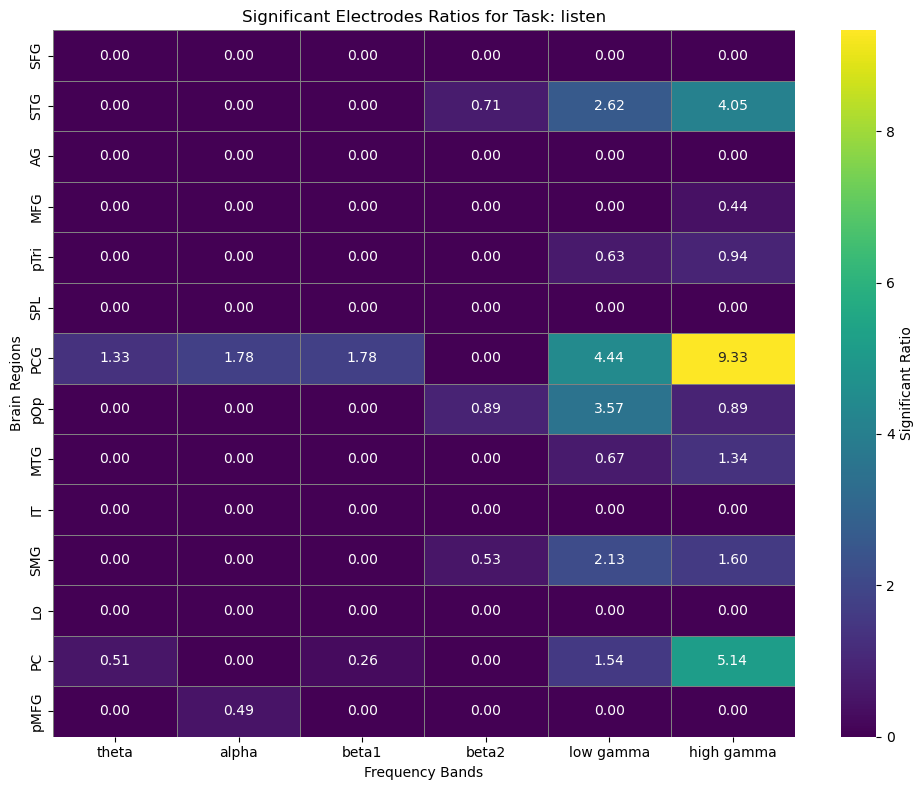

In [24]:
for task in task_time.keys():
    # print(task)
    task_all_sigelecs = np.load(os.path.join(f'/public/DATA/overt_reading/t-test_results', f'{task}_all_sigelecs.npy'), allow_pickle=True).item()
    # for band in bands_list:
        # plot_retion_regions(task, task_all_sigelecs[task], band)
    plot_task_heatmap(task, task_all_sigelecs[task], HS_list, bands_list)
# plot_retion_regions('Read')